

# Installing dependecies and loading data

In [1]:
!pip install -r requirements.txt
#installing depedencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 14.4 MB/s eta 0:00:00


In [21]:
#importing libraries
import numpy as np
import pandas as pd 
import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, concatenate, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.losses import mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

In [3]:
tensorflow.config.list_physical_devices('GPU')
#to configure GPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#load the dataset
lcp_train = pd.read_csv("lcp_single_train.tsv.txt", sep="\t")
lcp_test=pd.read_csv("lcp_single_test.tsv.txt", sep="\t")

In [5]:
lcp_train.head()

,id,corpus,sentence,token,complexity
0,3ZLW647WALVGE8EBR50EGUBPU4P32A,bible,"Behold, there came up out of the river seven c...",river,0.000000
1,34R0BODSP1ZBN3DVY8J8XSIY551E5C,bible,I am a fellow bondservant with you and with yo...,brothers,0.000000
2,3S1WOPCJFGTJU2SGNAN2Y213N6WJE3,bible,"The man, the lord of the land, said to us, 'By...",brothers,0.050000
3,3BFNCI9LYKQN09BHXHH9CLSX5KP738,bible,Shimei had sixteen sons and six daughters; but...,brothers,0.150000
4,3G5RUKN2EC3YIWSKUXZ8ZVH95R49N2,bible,He has put my brothers far from me.\tbrothers\...,sons,0.055556


In [6]:
lcp_train.describe()

,complexity
count,7232.000000
mean,0.301485
std,0.133091
min,0.000000
25%,0.210526
50%,0.277778
75%,0.371250
max,0.861111


In [7]:
lcp_test.head()

,id,corpus,sentence,token,complexity
0,3K8CQCU3KE19US5SN890DFPK3SANWR,bible,"But he, beckoning to them with his hand to be ...",hand,0.000000
1,3Q2T3FD0ON86LCI41NJYV3PN0BW3MV,bible,"If I forget you, Jerusalem, let my right hand ...",hand,0.197368
2,3ULIZ0H1VA5C32JJMKOTQ8Z4GUS51B,bible,"the ten sons of Haman the son of Hammedatha, t...",hand,0.200000
3,3BFF0DJK8XCEIOT30ZLBPPSRMZQTSD,bible,Let your hand be lifted up above your adversar...,hand,0.267857
4,3QREJ3J433XSBS8QMHAICCR0BQ1LKR,bible,"Abimelech chased him, and he fled before him, ...",entrance,0.000000


In [8]:
lcp_test.describe()

,complexity
count,887.000000
mean,0.298403
std,0.128126
min,0.000000
25%,0.214286
50%,0.277778
75%,0.360243
max,0.777778


# Tokenization and Sequecing

Sentnece Vriable

In [9]:
#here set the tokenizer limit to 10000, i.e., we will have a dictionary with top 10,000 words
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(lcp_train['sentence'])
sent_seq = tokenizer.texts_to_sequences(lcp_train['sentence'])
max_seq_len = max(len(seq) for seq in sent_seq)
sent_seq = pad_sequences(sent_seq, maxlen=max_seq_len) #padding the sequences to have uniform length


Token Variable

In [10]:
#getting sequeces for the tokens
lcp_train.token=lcp_train.token.astype(str)
token = tokenizer.texts_to_sequences(lcp_train['token'])
max_word_len = max(len(w) for w in token)
token = pad_sequences(token, maxlen=max_word_len) #padding the tokens to have uniform length

Corpus variable

In [11]:
#converting it to one hot encoding as we have 3 sources, bible,biomed and europarl
onehot_encoder = OneHotEncoder(sparse=False)
corpus_encoded = onehot_encoder.fit_transform(lcp_train['corpus'].values.reshape(-1, 1)) 

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
print(corpus_encoded)

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


The idea is to consider even corpus in input to the model.


#Splitting the data and Building a base stacked RNN model

In [27]:
print('pre-procesing done')
print('Training Base Stacked RNN')

pre-procesing done
Training Base Stacked RNN


In [13]:
train_seq, val_seq, train_tok, val_tok, train_corpus, val_corpus, train_y, val_y = train_test_split(
    sent_seq, token, corpus_encoded, lcp_train['complexity'].values, test_size=0.2, random_state=42)
#splitting into train and validation set

In [14]:
#Initializing inputs
input_seq = Input(shape=(max_seq_len,)) #shape to max length of sentence sequence
input_token= Input(shape=(max_word_len,)) #shape to max length of tok sequence
input_corpus = Input(shape=(3,)) # as we have 3 values
#creating embeddings
x_sent_seq = Embedding(input_dim=10000, output_dim=128, input_length=max_seq_len)(input_seq)
x_tok = Embedding(input_dim=10000, output_dim=128, input_length=max_word_len)(input_token)
#defining stacked LSTM layes with droput and batchnormalization
x = LSTM(64, return_sequences=True)(x_sent_seq)
x = LSTM(32, return_sequences=True)(x)
x = LSTM(16)(x)
x = BatchNormalization()(x)
y = LSTM(64, return_sequences=True)(x_tok)
y = LSTM(32, return_sequences=True)(y)
y = LSTM(16)(y)
y = BatchNormalization()(y)
#merging the outputs from layers
merged = concatenate([x, y, input_corpus])
x = Dense(64, activation='relu')(merged)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(32, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
#finally getting one output
output = Dense(1, activation='sigmoid')(x)
#building the model
model = Model(inputs=[input_seq, input_token, input_corpus], outputs=output)


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 662)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 662, 128)     1280000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 128)       1280000     ['input_2[0][0]']                
                                                                                              

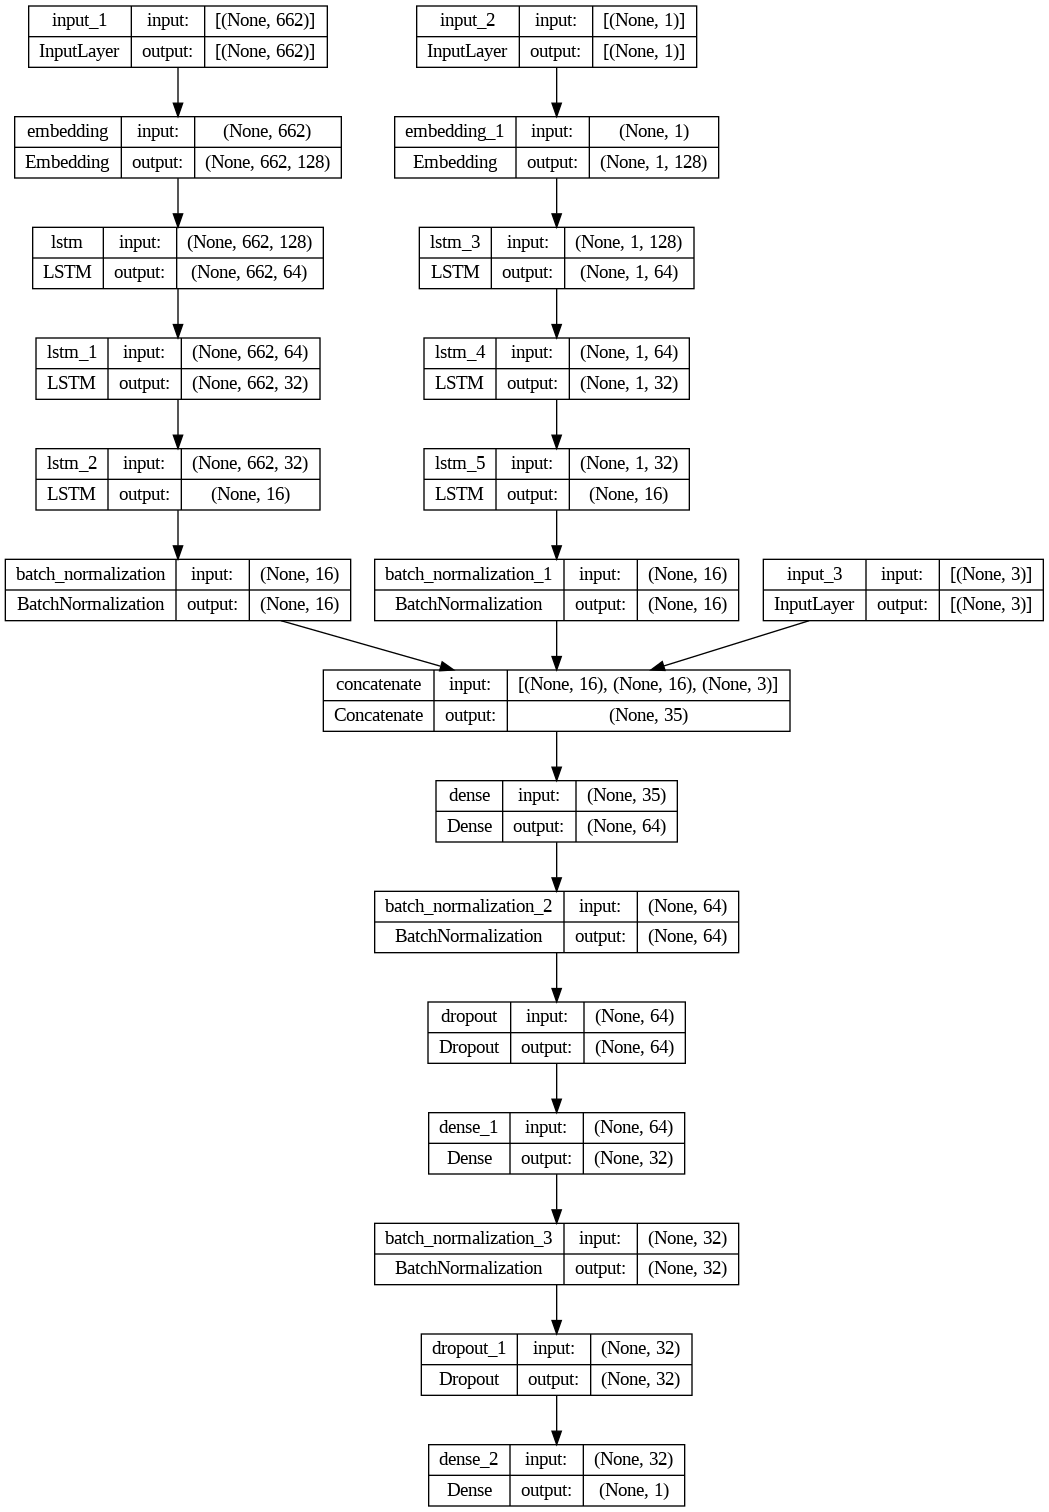

In [16]:
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
plot_model(model,show_shapes=True)

In [17]:
model.compile(loss=mean_absolute_error, optimizer='adam',metrics='accuracy')

In [18]:
history = model.fit([train_seq, train_tok, train_corpus], train_y, epochs=10, batch_size=32, validation_data=([val_seq, val_tok, val_corpus], val_y))
model.save("Stack_RNN.h5")

Epoch 1/10
181/181 [==============================] - 75s 285ms/step - loss: 0.2419 - accuracy: 0.0010 - val_loss: 0.1369 - val_accuracy: 0.0028
Epoch 2/10
181/181 [==============================] - 21s 116ms/step - loss: 0.1610 - accuracy: 0.0022 - val_loss: 0.1076 - val_accuracy: 0.0028
Epoch 3/10
181/181 [==============================] - 19s 104ms/step - loss: 0.1317 - accuracy: 0.0021 - val_loss: 0.1062 - val_accuracy: 0.0028
Epoch 4/10
181/181 [==============================] - 17s 94ms/step - loss: 0.1104 - accuracy: 0.0022 - val_loss: 0.1033 - val_accuracy: 0.0028
Epoch 5/10
181/181 [==============================] - 14s 80ms/step - loss: 0.0943 - accuracy: 0.0022 - val_loss: 0.0880 - val_accuracy: 0.0028
Epoch 6/10
181/181 [==============================] - 14s 79ms/step - loss: 0.0841 - accuracy: 0.0022 - val_loss: 0.0817 - val_accuracy: 0.0028
Epoch 7/10
181/181 [==============================] - 15s 84ms/step - loss: 0.0762 - accuracy: 0.0022 - val_loss: 0.0796 - val_accura

In [19]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


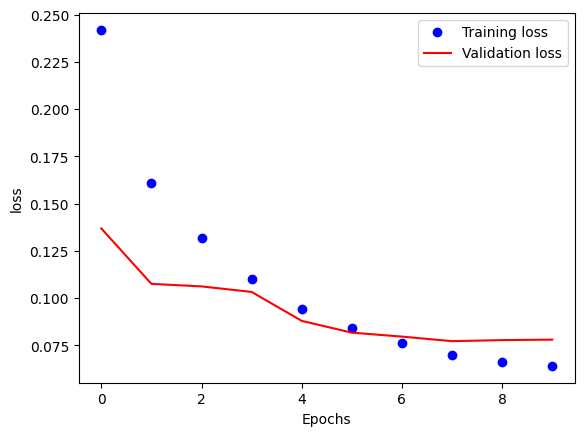

In [20]:
# Plot the loss curve with best hp and val loss
import matplotlib.pyplot as plt
%matplotlib inline
epochs=range(10)
train_acc=history.history['loss']
valid_acc = history.history['val_loss']
plt.plot(epochs,train_acc,'bo',label='Training loss')
plt.plot(epochs,valid_acc,'r',label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

# Tuning the stacked RNN model

In [ ]:
print('Base model trained')
print('Tuning Hyper parameters using keras tuner')

In [23]:
#ref : https://keras.io/keras_tuner/
#fuction to tune the hyper parameters - selected three things to tune 1.Optimizer 2. learning rate 3.Dropout Rate
def tuning(hp):
  input_seq = Input(shape=(max_seq_len,)) 
  input_token= Input(shape=(max_word_len,))
  input_corpus = Input(shape=(3,)) # as we have 3 values

  x_sent_seq = Embedding(input_dim=10000, output_dim=128, input_length=max_seq_len)(input_seq)
  x_tok = Embedding(input_dim=10000, output_dim=128, input_length=max_word_len)(input_token)

  x = LSTM(64, return_sequences=True)(x_sent_seq)
  x = LSTM(32, return_sequences=True)(x)
  x = LSTM(16)(x)
  x = BatchNormalization()(x)

  y = LSTM(64, return_sequences=True)(x_tok)
  y = LSTM(32, return_sequences=True)(y)
  y = LSTM(16)(y)
  y = BatchNormalization()(y)

  merged = concatenate([x, y, input_corpus])

  x = Dense(64, activation='relu')(merged)
  x = BatchNormalization()(x)
  x = Dropout(hp.Choice(name='dropout',values=[0.2,0.5,0.7]))(x)

  x = Dense(32, activation='relu')(x)
  x = BatchNormalization()(x)
  x = Dropout(hp.Choice(name='dropout',values=[0.2,0.5,0.7]))(x)

  output = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=[input_seq, input_token, input_corpus], outputs=output)

  
  optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
  if optimizer == 'adam':
    optimizer = tensorflow.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))
  else:
    optimizer = tensorflow.keras.optimizers.RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4]))

  model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                  metrics=['accuracy'])
  return model



In [24]:
tuner = kt.RandomSearch(
    tuning,
    objective='val_loss')

In [67]:
stop_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Perform hypertuning
tuner.search([train_seq, train_tok, train_corpus], train_y, epochs=30,batch_size=64,validation_data=([val_seq, val_tok, val_corpus], val_y),callbacks=[stop_early])
best_hp=tuner.get_best_hyperparameters()[0]

Trial 10 Complete [00h 02m 07s]
val_loss: 0.12010029703378677

Best val_loss So Far: 0.07614786177873611
Total elapsed time: 00h 28m 47s


In [69]:
print('Best Learning Rate: ',best_hp.get('learning_rate'))
print('Best Optimizer :',best_hp.get('optimizer'))
print('Best Dropout Rate: ',best_hp.get('dropout'))


Best Learning Rate:  0.01
Best Optimizer : rmsprop
Best Dropout Rate:  0.5


# Re-training on the whole training set with tuned parameters

In [28]:
print('Retraining using whole training dataset with best params')

Retraining using whole training dataset with best params


In [25]:
model.compile(loss=mean_absolute_error, optimizer=tensorflow.optimizers.RMSprop(learning_rate=0.01),metrics='accuracy')

In [26]:
history = model.fit([sent_seq, token, corpus_encoded], lcp_train['complexity'].values, epochs=30, batch_size=32)
model.save("Tuned_Stack_RNN.h5")

Epoch 1/30
226/226 [==============================] - 43s 142ms/step - loss: 0.0739 - accuracy: 0.0024
Epoch 2/30
226/226 [==============================] - 20s 88ms/step - loss: 0.0703 - accuracy: 0.0024
Epoch 3/30
226/226 [==============================] - 17s 77ms/step - loss: 0.0667 - accuracy: 0.0024
Epoch 4/30
226/226 [==============================] - 16s 69ms/step - loss: 0.0647 - accuracy: 0.0024
Epoch 5/30
226/226 [==============================] - 15s 66ms/step - loss: 0.0642 - accuracy: 0.0024
Epoch 6/30
226/226 [==============================] - 14s 61ms/step - loss: 0.0630 - accuracy: 0.0024
Epoch 7/30
226/226 [==============================] - 14s 62ms/step - loss: 0.0619 - accuracy: 0.0024
Epoch 8/30
226/226 [==============================] - 14s 63ms/step - loss: 0.0614 - accuracy: 0.0024
Epoch 9/30
226/226 [==============================] - 14s 64ms/step - loss: 0.0604 - accuracy: 0.0024
Epoch 10/30
226/226 [==============================] - 14s 63ms/step - loss: 0.05

In [29]:
print('Tuned model trained')

Tuned model trained
